In [1]:
import torch
import torch.nn as nn
import os
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import random
import math
import csv

In [2]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Adjust the number of filters
class CNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNN, self).__init__()
        self.in_channels = 32  # Reduce the initial number of channels

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the model
# cnn_model = CNN(BasicBlock, [2, 2, 2, 2]).to(device)
cnn_model = CNN(BasicBlock, [3, 4, 6, 3]).to(device)

model_weights_path = "/content/drive/My Drive/CNN_Model/cnn_model_weights.pth"
cnn_model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))

# Set the model to evaluation mode
cnn_model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1

In [5]:
# define paths to image folders
folder_paths = {
    'New York': '/content/drive/My Drive/Filtered_Images/NewYork_filtered',
    'New Orleans': '/content/drive/My Drive/Filtered_Images/NewOrleans_filtered',
    'London': '/content/drive/My Drive/Filtered_Images/London_filtered'
}

# Define image preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

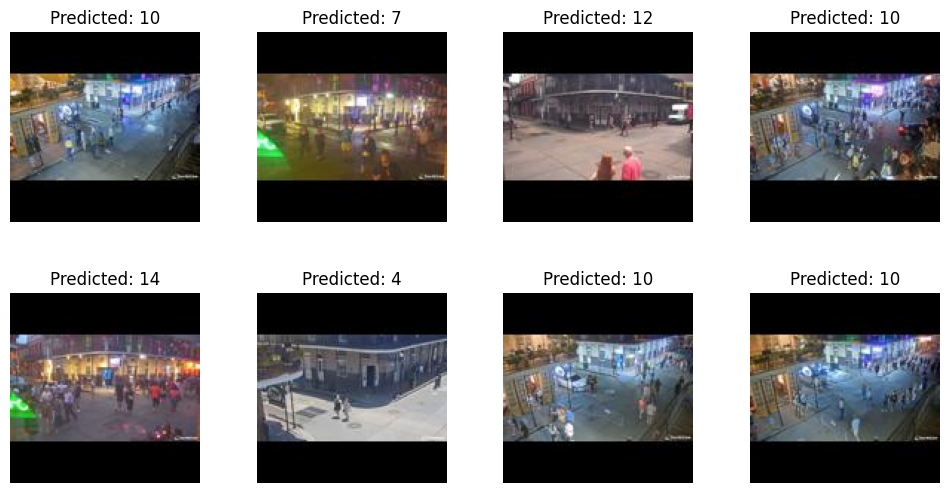

In [6]:
# visualize how model works on the images

def visualize_prediction(model, city, year, number_of_images):
    model.eval()

    image_dir = folder_paths[city]
    image_files = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            parts = filename.split('_')
            city_name = parts[0]
            date = parts[1]
            file_year = date.split('-')[-1]
            if file_year == year:
                image_files.append(filename)

    # Randomly select indices
    random_indices = random.sample(range(len(image_files)), number_of_images)

    rows = math.ceil(number_of_images / 4)
    cols = min(4, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, idx in enumerate(random_indices):
        filename = image_files[idx]
        image_path = os.path.join(image_dir, filename)

        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image = preprocess(image).unsqueeze(0).to(device)

        # Predict using the model
        predicted_count = model(image)
        predicted_count = torch.round(predicted_count).item()

        # Convert tensor to numpy for display
        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        # image_np = image_np * 0.5 + 0.5  # Assuming the image was normalized to [-1, 1]

        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]

        ax.imshow(image_np)
        ax.set_title(f"Predicted: {int(predicted_count)}")
        ax.axis('off')

    plt.show()

# Visualize the prediction for the first image in the validation set
visualize_prediction(cnn_model, "New Orleans", "2022", number_of_images=8)

In [30]:
def load_ground_truth(file_path):
    ground_truth = {}
    with open(file_path, mode='r') as file:
        if file_path.endswith('.csv'):
            reader = csv.reader(file)
            next(reader)  # Skip the header
            for row in reader:
                filename, count = row
                ground_truth[filename] = int(count)
        elif file_path.endswith('.json'):
            ground_truth = json.load(file)
    return ground_truth

def extract_date_from_filename(filename):
    # Split the filename to get the date
    parts = filename.split('_')
    if len(parts) >= 2:
        date_part = parts[1]
        # Convert the date part into a datetime object
        date_obj = datetime.strptime(date_part, "%m-%d-%Y")
        return date_obj
    return None

def visualize_ground_truth_predictions(model, ground_truth_file, city, predictions_dict):
    # Load the ground truth data
    ground_truth = load_ground_truth(ground_truth_file)

    # Extract and sort filenames by date
    sorted_ground_truth = sorted(ground_truth.items(), key=lambda item: extract_date_from_filename(item[0]))

    # Set the directory where images are stored
    image_dir = folder_paths[city]

    # Determine the number of images
    number_of_images = len(sorted_ground_truth)

    # Set up the plot grid
    rows = math.ceil(number_of_images / 3)
    cols = min(3, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.0)

    for i, (filename, gt_count) in enumerate(sorted_ground_truth):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image = preprocess(image).unsqueeze(0).to(device)

        # Predict using the model
        predicted_count = model(image)
        predicted_count = torch.round(predicted_count).item()

        # Store predictions and ground truth in the dictionary
        predictions_dict[filename] = {'ground_truth': gt_count, 'predicted': int(predicted_count)}

        # Convert tensor to numpy for display
        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

        # Extract the date from the filename
        date = extract_date_from_filename(filename).strftime("%m-%d-%Y")

        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]

        ax.imshow(image_np)
        ax.set_title(f"Date: {date}\nPredicted: {int(predicted_count)}, Ground Truth: {gt_count}")
        ax.axis('off')

    plt.show()

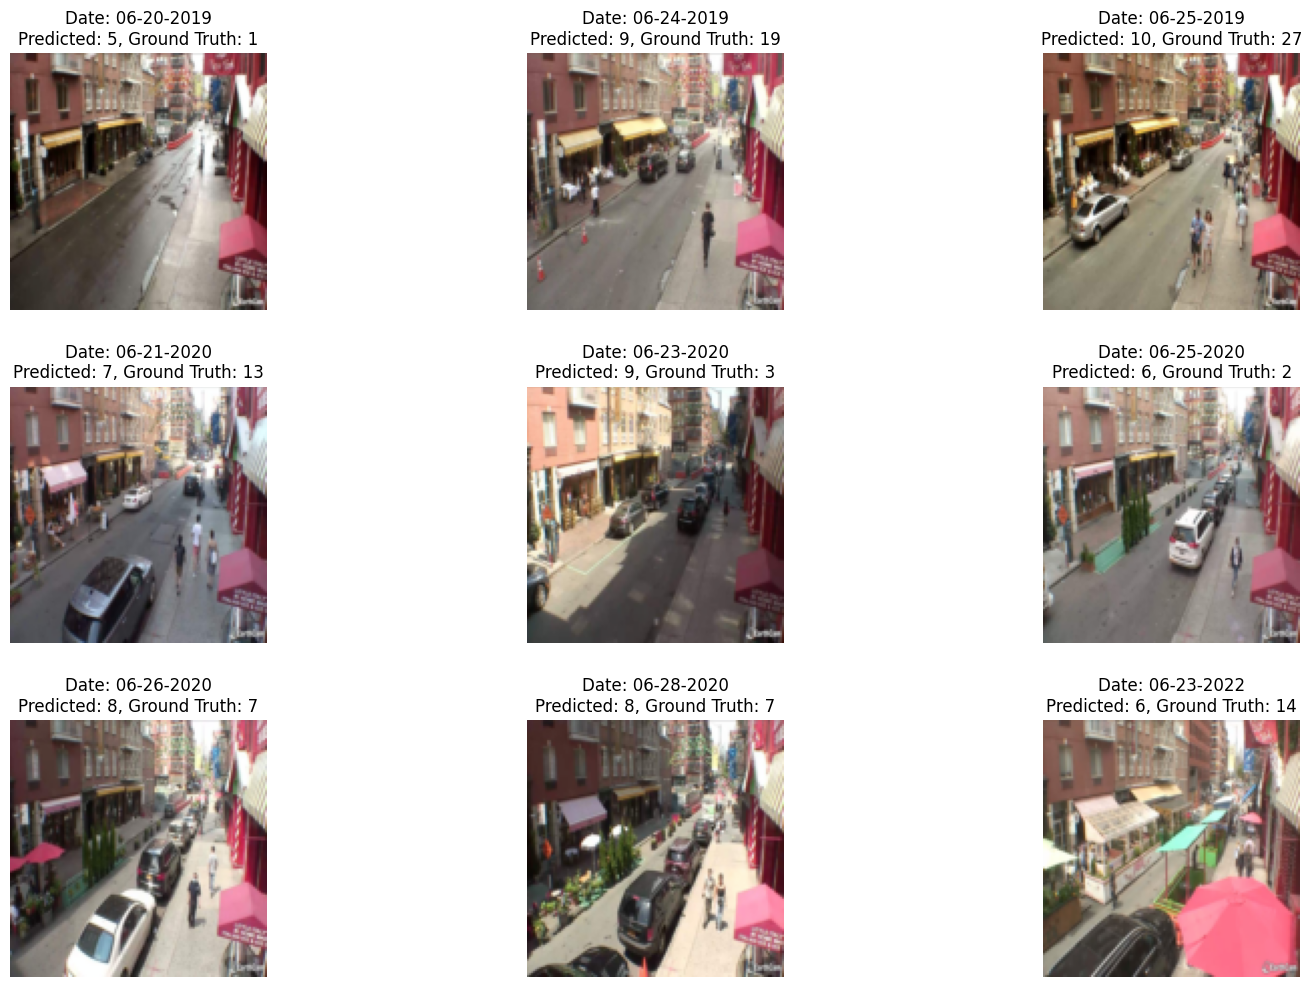

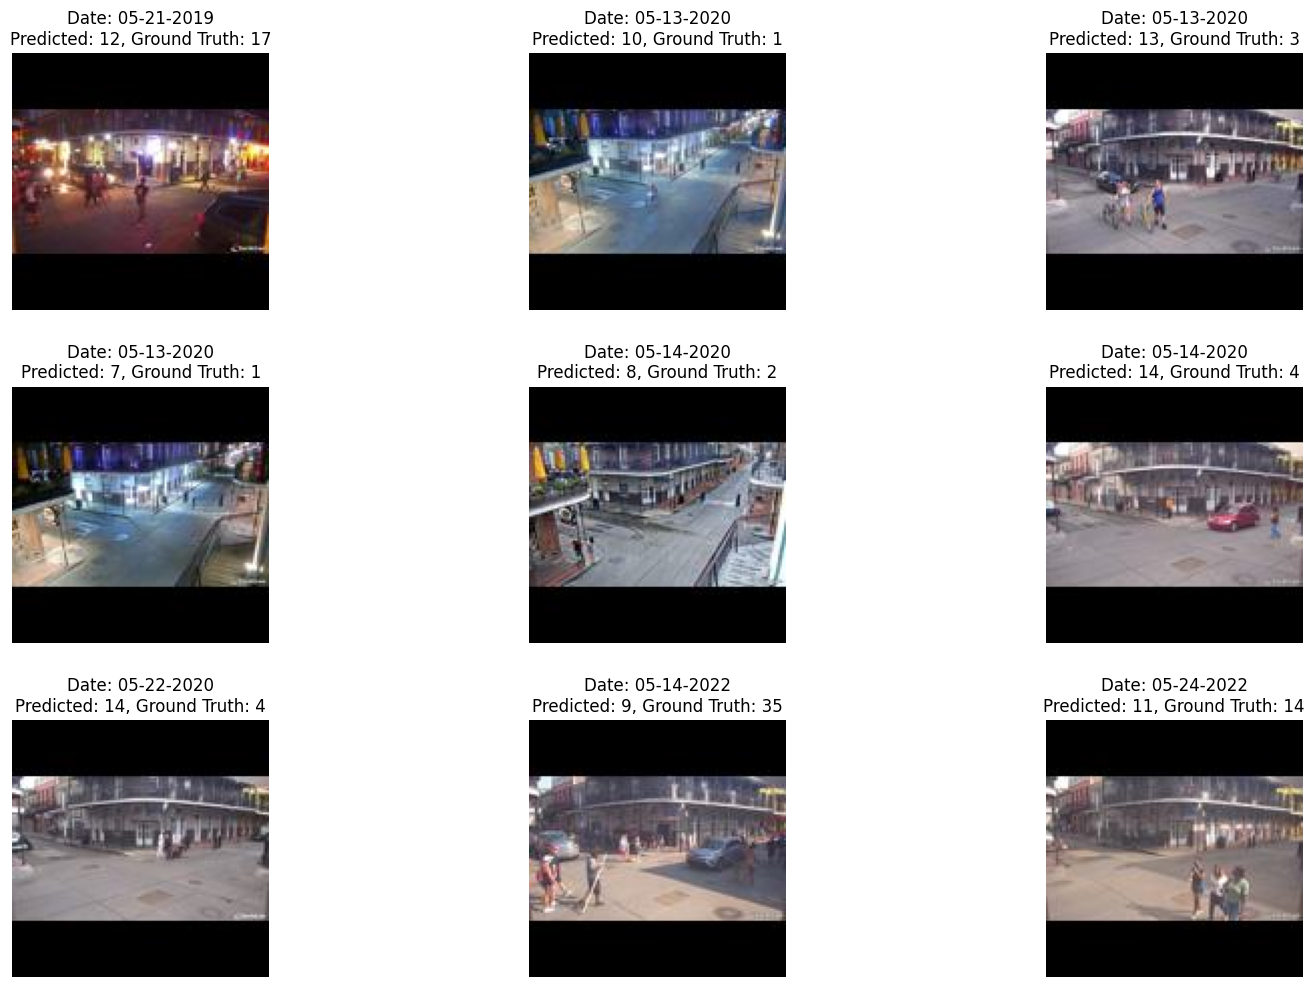

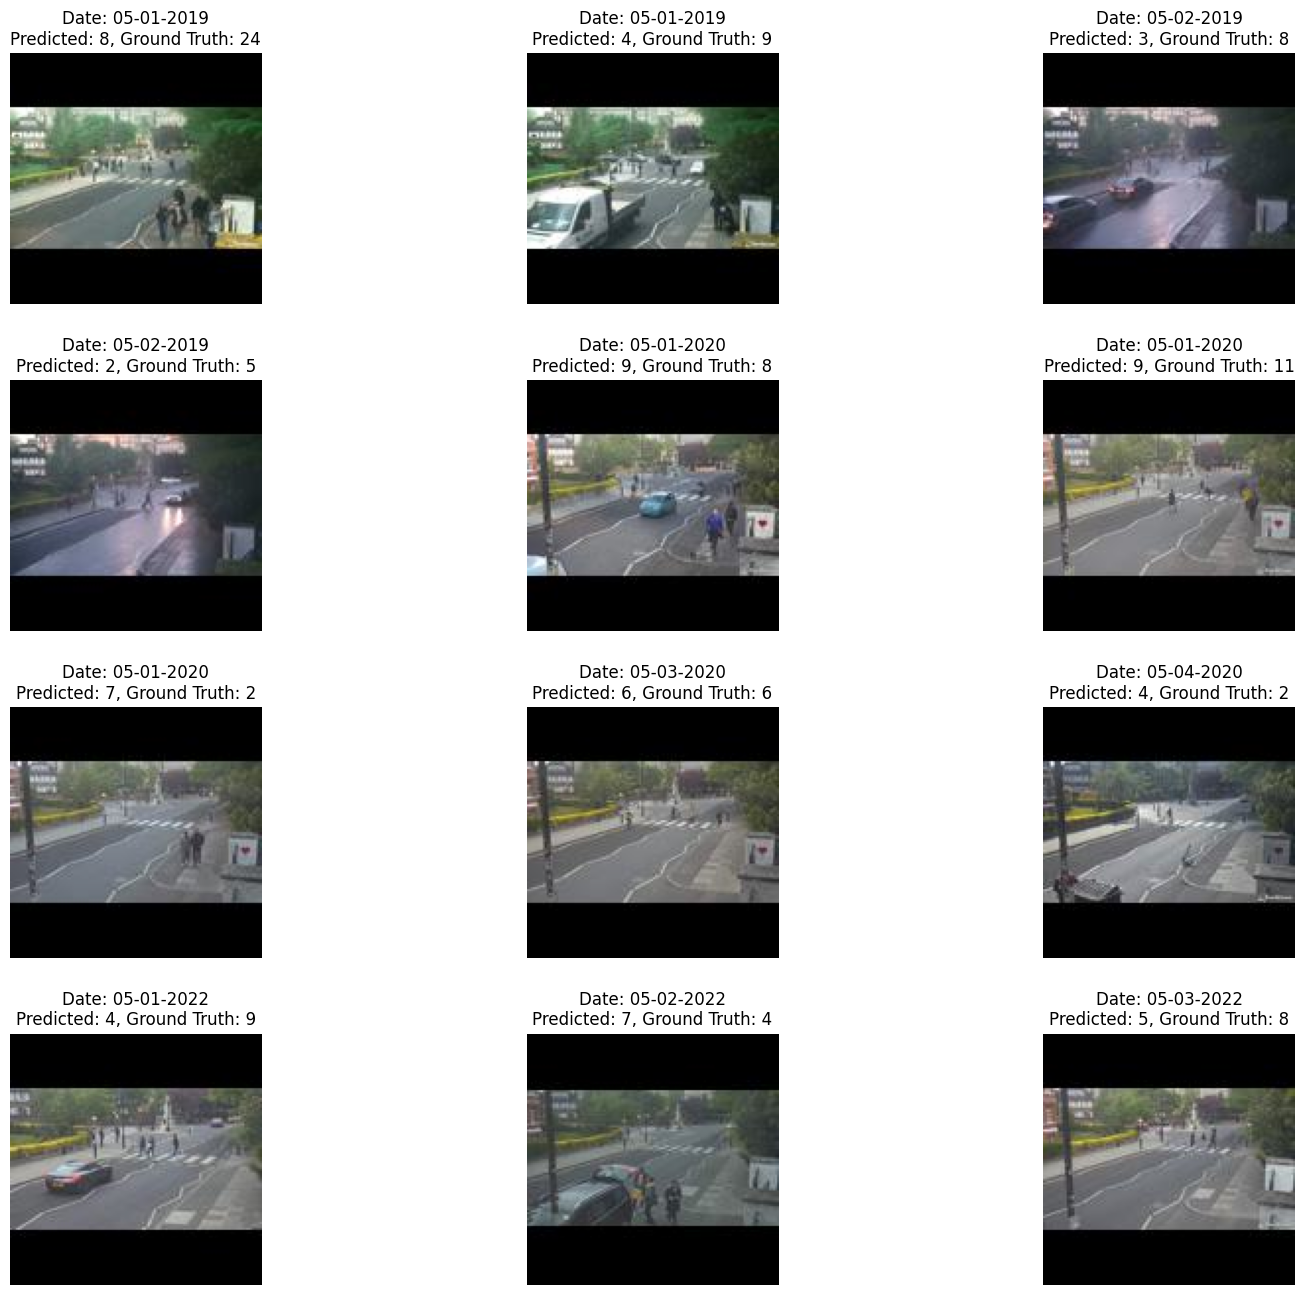

In [31]:
all_predictions = {}

ground_truth_csv_paths = {
    'New York': '/content/drive/My Drive/Manual_Annotations/ground_truth_New_York_filtered.csv',
    'New Orleans': '/content/drive/My Drive/Manual_Annotations/ground_truth_New_Orleans_filtered.csv',
    'London': '/content/drive/My Drive/Manual_Annotations/ground_truth_London_filtered.csv'
}

for city, path in ground_truth_csv_paths.items():
  visualize_ground_truth_predictions(cnn_model, path, city, all_predictions)

In [40]:
# Extract ground truth and predicted values
ground_truths = [data['ground_truth'] for data in all_predictions.values()]
predictions = [data['predicted'] for data in all_predictions.values()]

# Calculate MAE, MSE, RMSE
mae = np.mean(np.abs(np.array(ground_truths) - np.array(predictions)))
mse = np.mean((np.array(ground_truths) - np.array(predictions)) ** 2)
rmse = np.sqrt(mse)

mae, mse, rmse

(6.4, 70.46666666666667, 8.394442606073774)